# Как проводил кластеризацию (параметры, метрики, методы) и какие кластеры в итоге получились

## Необходимые библиотеки

In [2]:
# для работы с данными
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# для кодировки данных
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
# для кластеризации и метрик
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.mixture import GaussianMixture

## Кластеризация

> Кластеризация будет проводиться только для БД с ЮЛ. Для ИП относительно маленький датасет

> Было проведено несколько итерация с подбором оптимальной модели, метрик и метода кодировки данных

> В итоге пришел к данному варианту:  
    > кодировка - minmaxscaler для числовых, onehotencoder для категориальных (без региона и вида деятельности)  
    > подбор количества кластеров и метрики качества: Индекс Дэвиса-Болдина, Метод Силуэта  
    > алгоритм: k-means

### Обработка и кодировка

In [202]:
df = pd.read_csv('rnp_companies_fin_employees_info_final_final.csv',
                      encoding='utf-8',
                      dtype={'supplier_inn': str,
                            'main_okved_code_class': str,
                            'region_code': object
                            })

In [203]:
# Выбираем нужные столбцы
df = df[['date_diff_between_reg_entry',
         'rnp_reason',
         'contract_price_amount',
         'history_signed_contract_before_rnp',
         'history_sum_price_before_rnp',
         'employees',
         'Денежные средства и денежные эквиваленты',
         'Кредиторская задолженность',
         'Выручка',
         'Чистая прибыль (убыток)']].copy()

In [204]:
# Обработка пропущенных значений
# Заполнение медианой для числовых переменных и модой для категориальных
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].fillna(df[column].mode()[0])
    else:
        df[column] = df[column].fillna(df[column].median())

In [205]:
def preprocess_data(df):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    scaler = MinMaxScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    onehot = OneHotEncoder()
    categorical_cols = ['rnp_reason']
    categorical_encoded = pd.DataFrame(onehot.fit_transform(df[categorical_cols]).toarray(), columns=onehot.get_feature_names_out(categorical_cols))

    df = pd.concat([df.drop(columns=categorical_cols), categorical_encoded], axis=1)

    return df

df_prep = preprocess_data(df)

In [207]:
df_prep.to_csv('comp_for_clusterization_iteraion_4.csv', index=False)

### Поиск оптимального числа кластеров

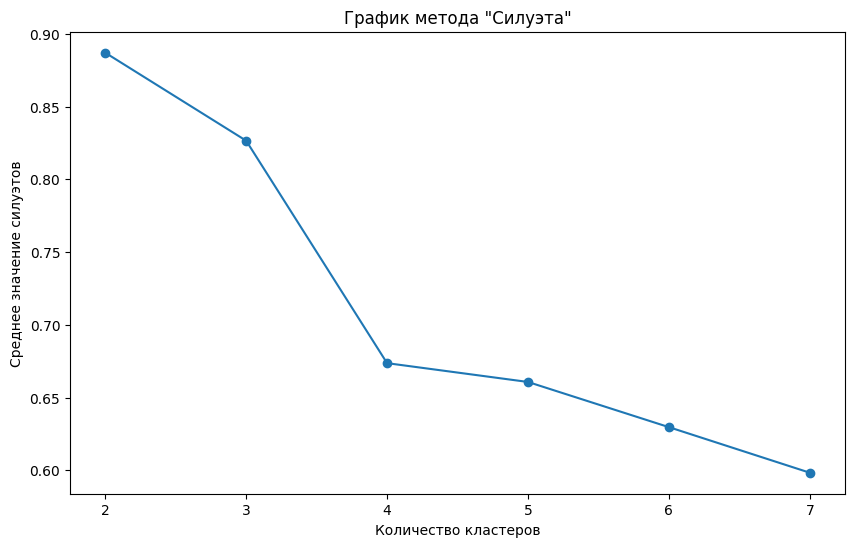

In [208]:
df = df_prep

# Преобразуем DataFrame в массив numpy
data = df.to_numpy()

# Метод силуэта
def silhouette_method(data, max_clusters=7):
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))

    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Среднее значение силуэтов')
    plt.title('График метода "Силуэта"')
    #plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ЮЛ\метод силуэта.png') 
    plt.show()

silhouette_method(data)

### Модель кластеризации

In [209]:
df = df_prep
# Преобразуем DataFrame в массив numpy
data = df.to_numpy()

# Создаем и применяем модель KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)

# Получаем кластеры для каждой точки данных
labels = kmeans.labels_

# Добавляем метки в DataFrame
df['Cluster'] = labels

In [210]:
df['Cluster'].value_counts()

Cluster
0    28601
1    14656
2     6121
Name: count, dtype: int64

In [211]:
X = df.iloc[:, :-1].values  # Берем все столбцы, кроме последнего, как признаки
y_kmeans = df['Cluster'].values  # Последний столбец содержит метки кластеров

# Расчет метрик кластеризации
silhouette = silhouette_score(X, y_kmeans)
db_score = davies_bouldin_score(X, y_kmeans)

print(f"Индекс силуэта: {silhouette}")
print(f"Индекс Дэвиса-Болдина: {db_score}")

Индекс силуэта: 0.7354273854003991
Индекс Дэвиса-Болдина: 0.4447727222415141


Соотнесем полученные кластеры с исходным датасетом

In [212]:
df_init= pd.read_csv('rnp_companies_fin_employees_info_final_final.csv',
                      encoding='utf-8',
                      dtype={'supplier_inn': str,
                            'main_okved_code_class': str,
                            'region_code': object
                            })

combined_df = pd.concat([df_init, df['Cluster']], axis=1)

In [213]:
combined_df.to_csv('clusterized_iteration_4.csv', index=False)

## Интерпретация кластеров

In [3]:
df = pd.read_csv('clusterized_iteration_4.csv',
                      encoding='utf-8',
                      dtype={'supplier_inn': str,
                            'main_okved_code_class': str,
                            'region_code': object
                            })

In [31]:
df['Cluster'].value_counts()

Cluster
1    28601
2    14656
3     6121
Name: count, dtype: int64

### Разница между регистрацией и входом в РНП

<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_19176\3565486359.py:13: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\Кластеризация\ЮЛ\боксплот разница дат.png')


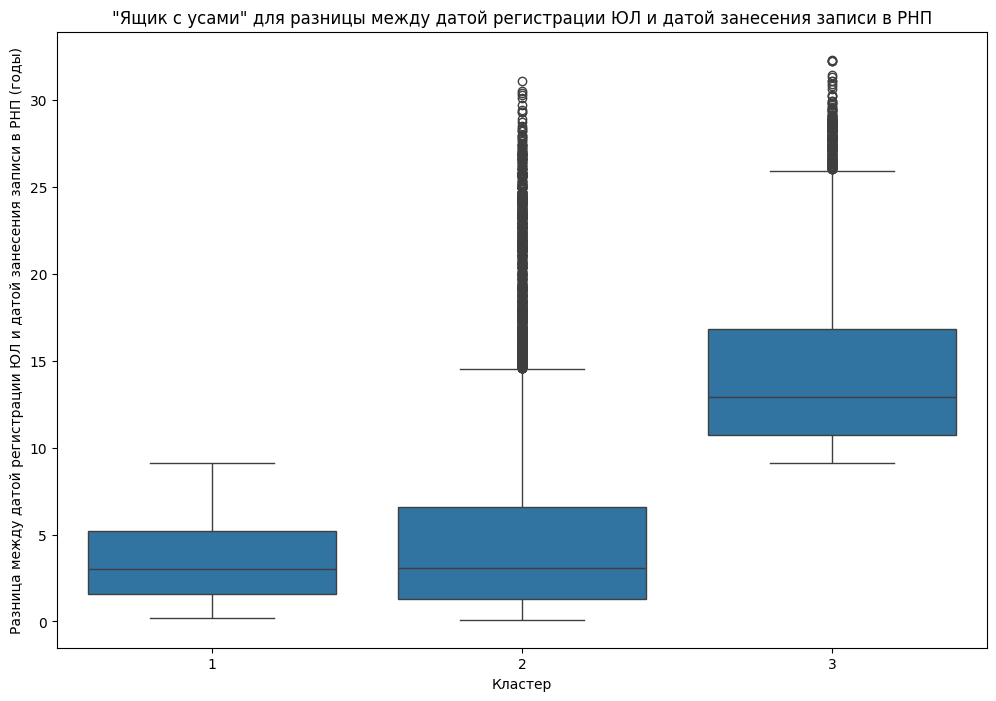

Statistics for Cluster 1:
count    28537.000000
mean         3.584347
std          2.383454
min          0.200000
25%          1.600000
50%          3.000000
75%          5.200000
max          9.100000
Name: date_diff_between_reg_entry, dtype: float64

Statistics for Cluster 2:
count    14613.000000
mean         4.879272
std          5.117135
min          0.100000
25%          1.300000
50%          3.100000
75%          6.600000
max         31.100000
Name: date_diff_between_reg_entry, dtype: float64

Statistics for Cluster 3:
count    6121.000000
mean       14.622382
std         5.055273
min         9.100000
25%        10.700000
50%        12.900000
75%        16.800000
max        32.300000
Name: date_diff_between_reg_entry, dtype: float64



In [32]:
clusters = df.groupby('Cluster')['date_diff_between_reg_entry']

plt.figure(figsize=(12, 8))
sns.boxplot(x=df['Cluster'], y=df['date_diff_between_reg_entry'])

plt.title('"Ящик с усами" для разницы между датой регистрации ЮЛ и датой занесения записи в РНП')
plt.xlabel('Кластер')
plt.ylabel('Разница между датой регистрации ЮЛ и датой занесения записи в РНП (годы)')

plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\Кластеризация\ЮЛ\боксплот разница дат.png')

plt.show()

for cluster_id, data in clusters:
    print(f"Statistics for Cluster {cluster_id}:")
    print(data.describe())
    print()

### Причина добавления в РНП

<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_19176\2928502918.py:19: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\Кластеризация\ЮЛ\причина добавления.png')
C:\Users\ww\AppData\Local\Temp\ipykernel_19176\2928502918.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_reason_counts = df.groupby(['Cluster', 'rnp_reason']).size().unstack()


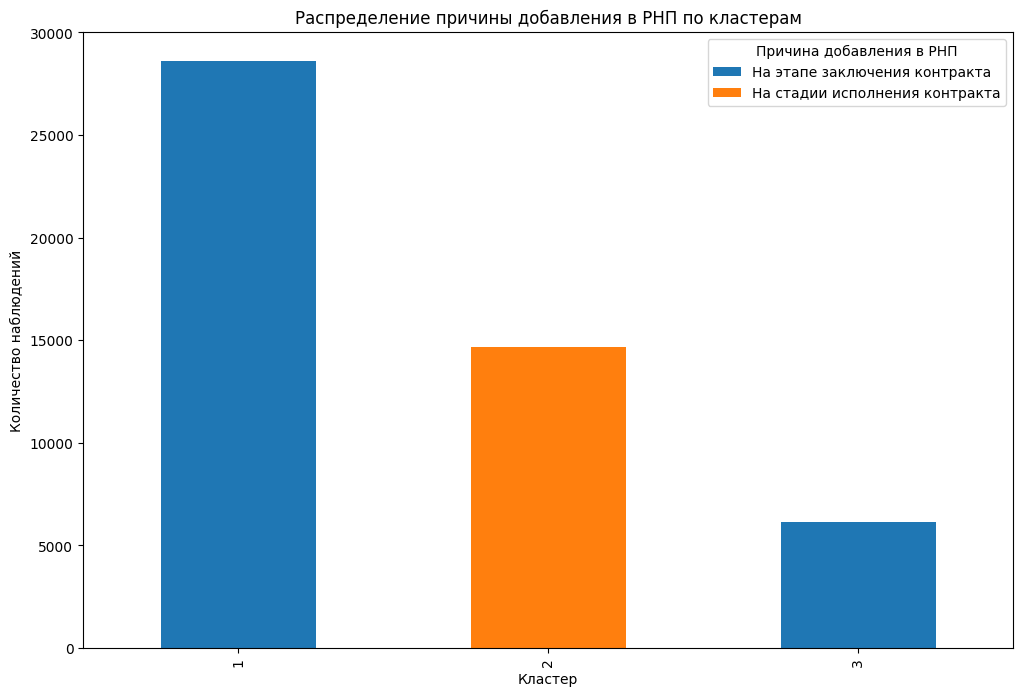

         На этапе заключения контракта  На стадии исполнения контракта
Cluster                                                               
1                                28601                               0
2                                    0                           14656
3                                 6121                               0


In [34]:
df['rnp_reason'] = df['rnp_reason'].astype('category')

cluster_reason_counts = df.groupby(['Cluster', 'rnp_reason']).size().unstack()

cluster_reason_counts.columns = ['На этапе заключения контракта', 'На стадии исполнения контракта']

cluster_reason_counts.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Распределение причины добавления в РНП по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Количество наблюдений')
plt.legend(title='Причина добавления в РНП')

plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\Кластеризация\ЮЛ\причина добавления.png')

plt.show()

print(cluster_reason_counts)

### Цены контракта

<>:34: SyntaxWarning: invalid escape sequence '\e'
<>:34: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_19176\725938144.py:34: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\Кластеризация\ЮЛ\цены контракта.png')


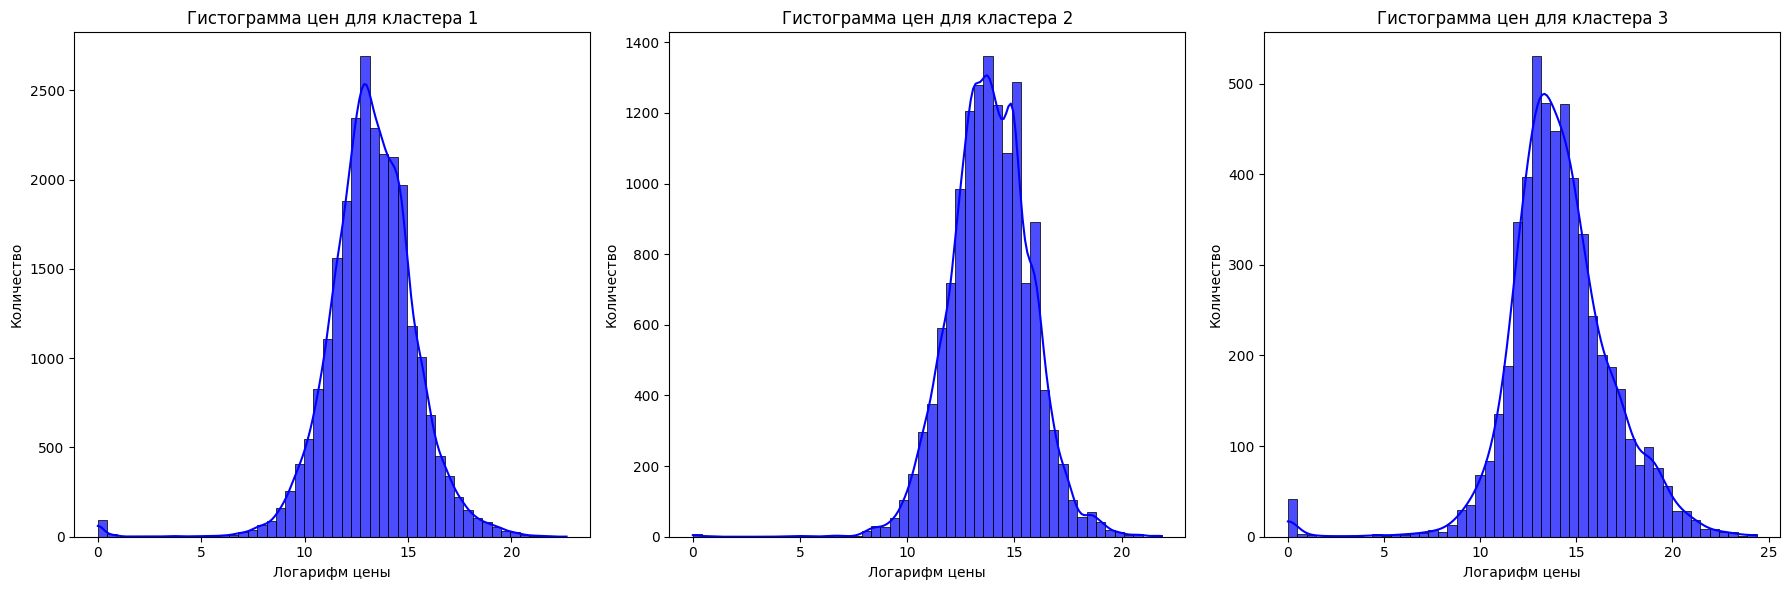

Descriptive statistics for Cluster 1:
count    2.504100e+04
mean     6.395809e+06
std      6.708351e+07
min      0.000000e+00
25%      1.709775e+05
50%      5.528280e+05
75%      2.001760e+06
max      6.951976e+09
Name: contract_price_amount, dtype: float64

Descriptive statistics for Cluster 2:
count    1.369300e+04
mean     7.330670e+06
std      5.856823e+07
min      0.000000e+00
25%      3.235400e+05
50%      1.018185e+06
75%      3.551464e+06
max      3.120474e+09
Name: contract_price_amount, dtype: float64

Descriptive statistics for Cluster 3:
count    5.357000e+03
mean     8.041332e+07
std      9.935070e+08
min      0.000000e+00
25%      3.048592e+05
50%      1.143676e+06
75%      5.751879e+06
max      3.847710e+10
Name: contract_price_amount, dtype: float64



In [35]:
clusters = df['Cluster'].unique()

num_clusters = len(clusters)
cols = 3 
rows = (num_clusters // cols) + (num_clusters % cols) 
fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))

axes = axes.flatten()

for i, cluster in enumerate(clusters):
    cluster_prices = df[df['Cluster'] == cluster]['contract_price_amount']  
    cluster_prices = np.array(cluster_prices)
    log_prices = np.log(cluster_prices + 1)  

    sns.histplot(log_prices, bins=50, ax=axes[i], kde=True, color='blue', alpha=0.7)

    axes[i].set_title(f'Гистограмма цен для кластера {cluster}')
    axes[i].set_xlabel('Логарифм цены')
    axes[i].set_ylabel('Количество')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()

plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\Кластеризация\ЮЛ\цены контракта.png')

plt.show()

for cluster in clusters:
    cluster_prices = df[df['Cluster'] == cluster]['contract_price_amount']    
    stats = pd.Series(cluster_prices).describe()
    print(f'Descriptive statistics for Cluster {cluster}:')
    print(stats)
    print()

### История закупок

<>:72: SyntaxWarning: invalid escape sequence '\e'
<>:72: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_19176\2142409225.py:72: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\Кластеризация\ЮЛ\история закупок.png')


Descriptive statistics for Cluster 1:
       history_signed_contract_before_rnp  history_sum_price_before_rnp
count                        28601.000000                  2.860100e+04
mean                           176.518373                  1.177326e+08
std                            444.509722                  4.016750e+08
min                              0.000000                  0.000000e+00
25%                             13.000000                  9.631810e+06
50%                             42.000000                  3.177798e+07
75%                            137.000000                  1.042859e+08
max                          22327.000000                  1.725216e+10

Descriptive statistics for Cluster 2:
       history_signed_contract_before_rnp  history_sum_price_before_rnp
count                        14656.000000                  1.465600e+04
mean                            96.007301                  6.946250e+07
std                            417.014282                  

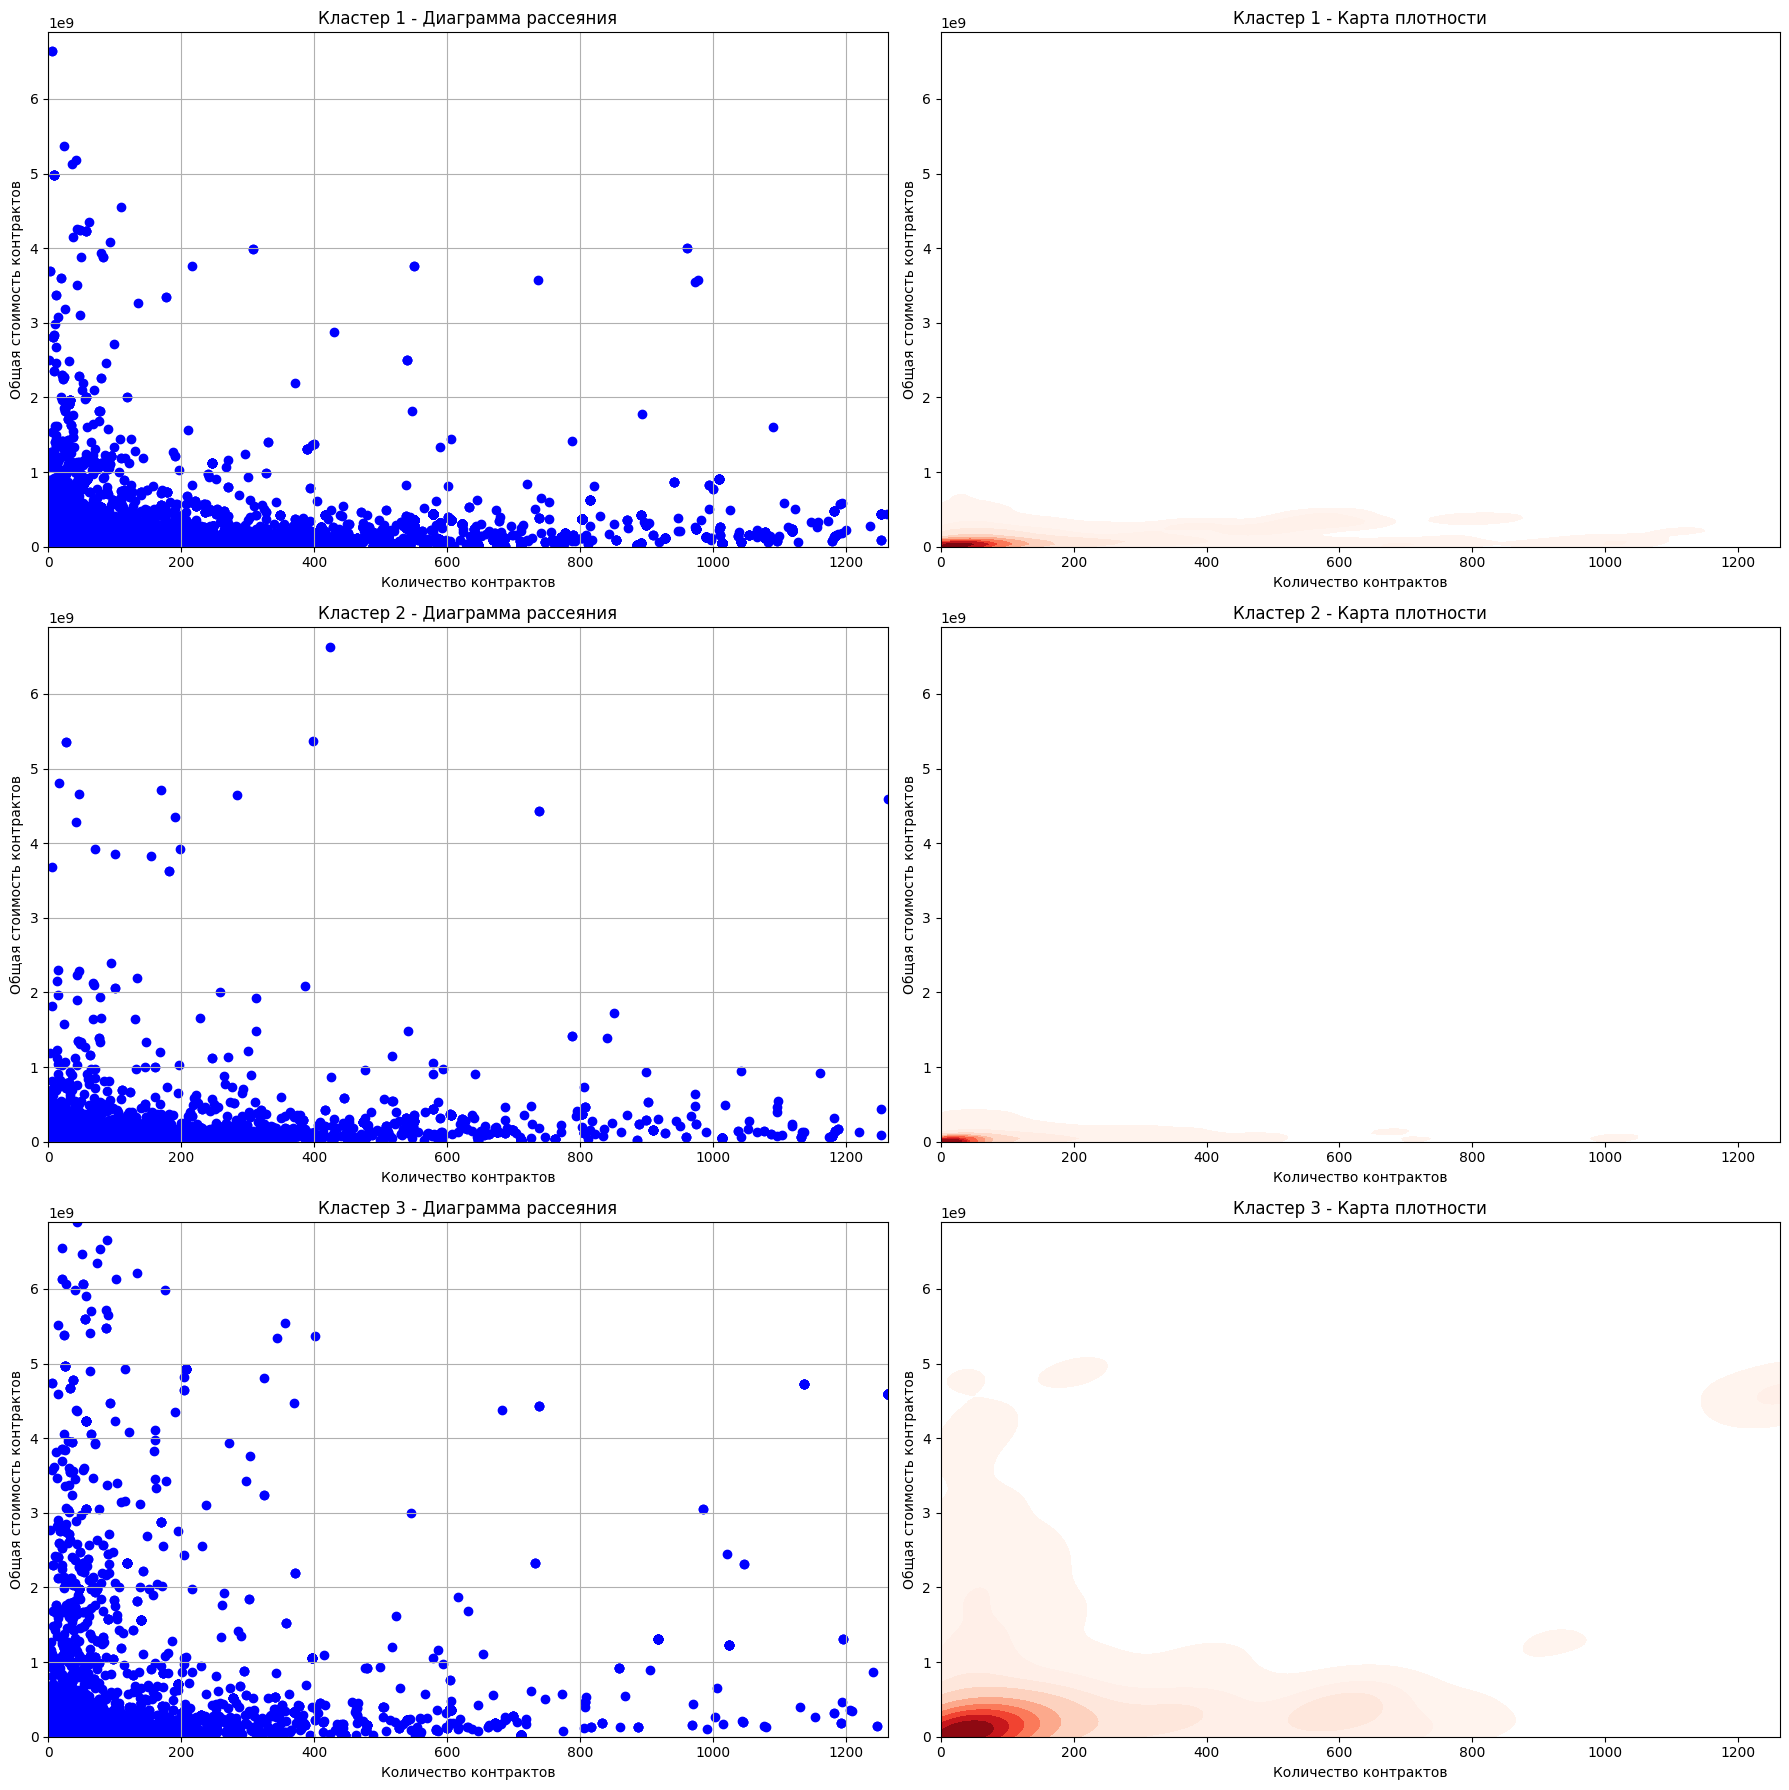

In [37]:
clusters = df['Cluster'].unique() 

max_contracts = 0
max_value = 0

for cluster in clusters:
    cluster_data = df[df['Cluster'] == cluster] 

    contracts_threshold = np.percentile(cluster_data['history_signed_contract_before_rnp'], 95)
    value_threshold = np.percentile(cluster_data['history_sum_price_before_rnp'], 95)

    max_contracts = max(max_contracts, contracts_threshold)
    max_value = max(max_value, value_threshold)

num_clusters = len(clusters)
cols = 2  
rows = num_clusters 
fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))

axes = axes.flatten()

for i, cluster in enumerate(clusters):
    cluster_data = df[df['Cluster'] == cluster] 

    cluster_data = cluster_data[
        (cluster_data['history_signed_contract_before_rnp'] <= max_contracts) &
        (cluster_data['history_sum_price_before_rnp'] <= max_value)
    ]

    axes[i * 2].scatter(
        cluster_data['history_signed_contract_before_rnp'],
        cluster_data['history_sum_price_before_rnp'],
        color='blue'
    )
    
    axes[i * 2].set_title(f'Кластер {cluster} - Диаграмма рассеяния')
    axes[i * 2].set_xlabel('Количество контрактов')
    axes[i * 2].set_ylabel('Общая стоимость контрактов')
    axes[i * 2].set_xlim(0, max_contracts)
    axes[i * 2].set_ylim(0, max_value)
    axes[i * 2].grid(True)

    sns.kdeplot(
        x=cluster_data['history_signed_contract_before_rnp'],
        y=cluster_data['history_sum_price_before_rnp'],
        ax=axes[i * 2 + 1],
        cmap="Reds",
        fill=True
    )

    axes[i * 2 + 1].set_title(f'Кластер {cluster} - Карта плотности')
    axes[i * 2 + 1].set_xlabel('Количество контрактов')
    axes[i * 2 + 1].set_ylabel('Общая стоимость контрактов')
    axes[i * 2 + 1].set_xlim(0, max_contracts)
    axes[i * 2 + 1].set_ylim(0, max_value)

fig.tight_layout()

plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\Кластеризация\ЮЛ\история закупок.png')

for cluster in clusters:
    cluster_data = df[df['Cluster'] == cluster] 
    
    print(f'Descriptive statistics for Cluster {cluster}:')
    print(cluster_data[['history_signed_contract_before_rnp', 'history_sum_price_before_rnp']].describe())
    print()


### Распределение по количеству сотрудников

<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_19176\362449312.py:18: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\Кластеризация\ЮЛ\количество сотрудников.png')
C:\Users\ww\AppData\Local\Temp\ipykernel_19176\362449312.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['percentile_95'] = df_test.groupby('Cluster')['employees'].transform(lambda x: np.percentile(x, 95))


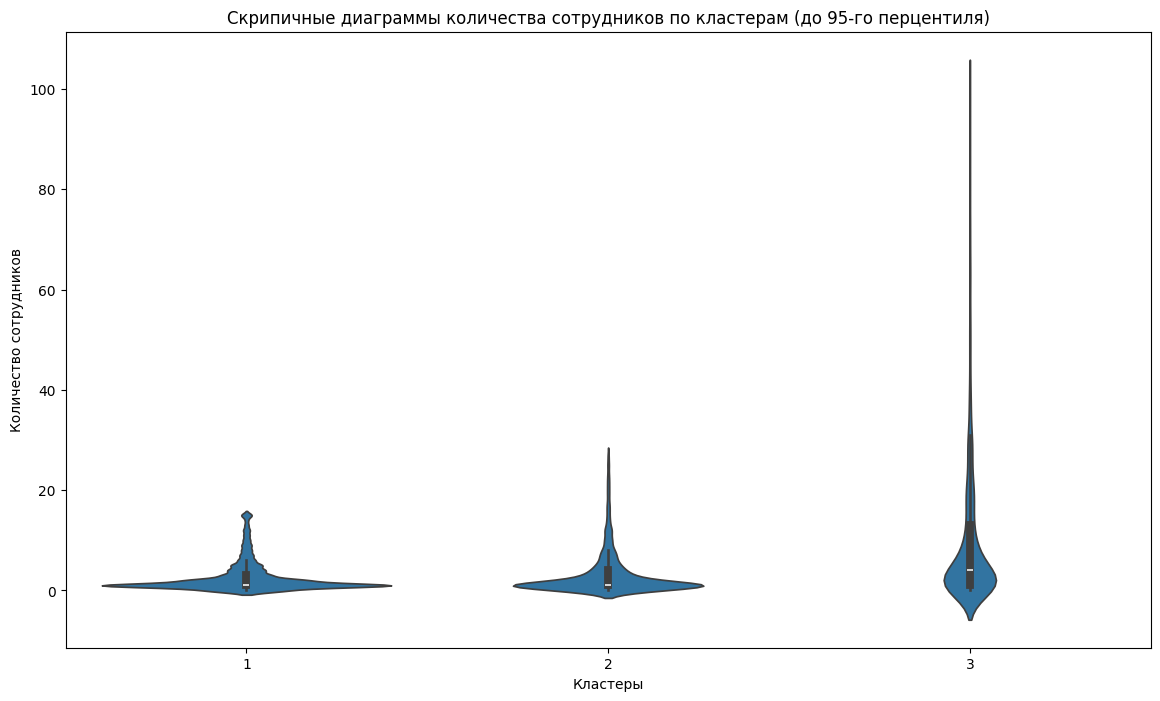

           count       mean        std  min  25%  50%   75%    max
Cluster                                                           
1        20273.0   2.617126   3.091652  0.0  1.0  1.0   3.0   15.0
2         7415.0   3.174646   4.425458  0.0  1.0  1.0   4.0   27.0
3         4409.0  10.276480  15.644546  0.0  1.0  4.0  13.0  100.0


In [38]:
df_test = df.dropna(subset=['employees', 'Cluster'])

df_test['percentile_95'] = df_test.groupby('Cluster')['employees'].transform(lambda x: np.percentile(x, 95))

filtered_df = df_test[df_test['employees'] <= df_test['percentile_95']]

plt.figure(figsize=(14, 8))
sns.violinplot(data=filtered_df, x='Cluster', y='employees')
plt.title('Скрипичные диаграммы количества сотрудников по кластерам (до 95-го перцентиля)')
plt.xlabel('Кластеры')
plt.ylabel('Количество сотрудников')

plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\Кластеризация\ЮЛ\количество сотрудников.png')

plt.show()

stat_summary = filtered_df.groupby('Cluster')['employees'].describe()
print(stat_summary)

### Распределение по фин показателям

<>:48: SyntaxWarning: invalid escape sequence '\e'
<>:48: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_19176\4029843303.py:48: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig(f'D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\Кластеризация\ЮЛ\финансы {variable}.png')


Анализ переменной: Денежные средства и денежные эквиваленты

Описательная статистика для кластера 1:
count    2.184700e+04
mean     2.954816e+06
std      6.701780e+07
min     -7.015000e+06
25%      1.200000e+04
50%      2.050000e+05
75%      1.246000e+06
max      8.775524e+09
Name: Денежные средства и денежные эквиваленты, dtype: float64

Описательная статистика для кластера 2:
count    1.083200e+04
mean     3.026751e+06
std      3.023347e+07
min     -5.999000e+06
25%      2.000000e+04
50%      1.930000e+05
75%      1.040500e+06
max      1.684613e+09
Name: Денежные средства и денежные эквиваленты, dtype: float64

Описательная статистика для кластера 3:
count    5.339000e+03
mean     2.538895e+07
std      4.253159e+08
min     -1.297500e+07
25%      4.200000e+04
50%      4.210000e+05
75%      2.831500e+06
max      2.813250e+10
Name: Денежные средства и денежные эквиваленты, dtype: float64


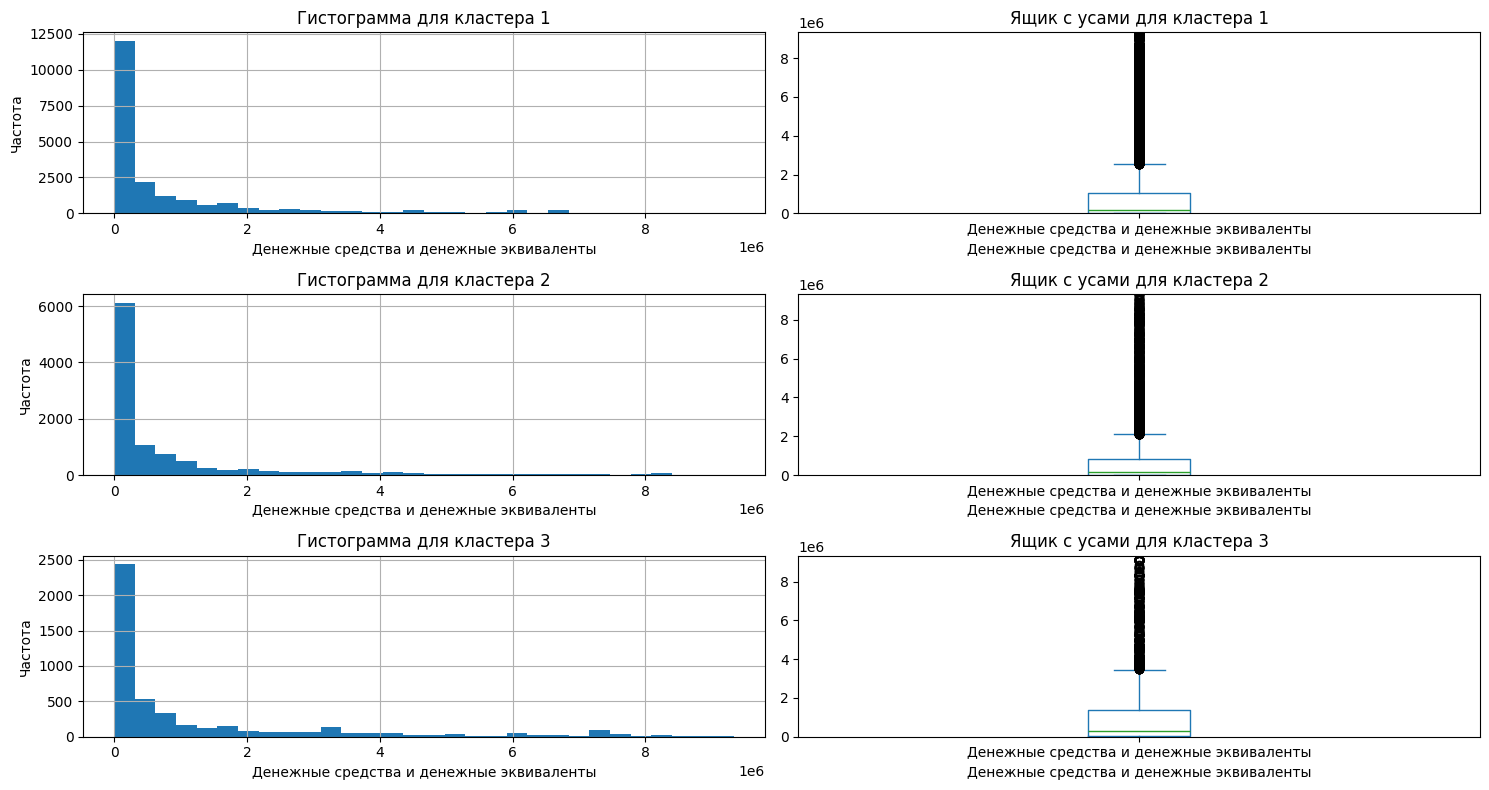

Анализ переменной: Кредиторская задолженность

Описательная статистика для кластера 1:
count    2.178100e+04
mean     3.295455e+07
std      3.978895e+08
min     -1.060000e+06
25%      6.020000e+05
50%      4.032000e+06
75%      2.006700e+07
max      5.299966e+10
Name: Кредиторская задолженность, dtype: float64

Описательная статистика для кластера 2:
count    1.049500e+04
mean     3.400177e+07
std      3.214675e+08
min     -8.670000e+05
25%      2.560000e+05
50%      2.232000e+06
75%      1.037600e+07
max      1.530166e+10
Name: Кредиторская задолженность, dtype: float64

Описательная статистика для кластера 3:
count    5.320000e+03
mean     3.884383e+08
std      3.049914e+09
min     -3.030000e+05
25%      1.319750e+06
50%      1.157050e+07
75%      5.837925e+07
max      1.325062e+11
Name: Кредиторская задолженность, dtype: float64


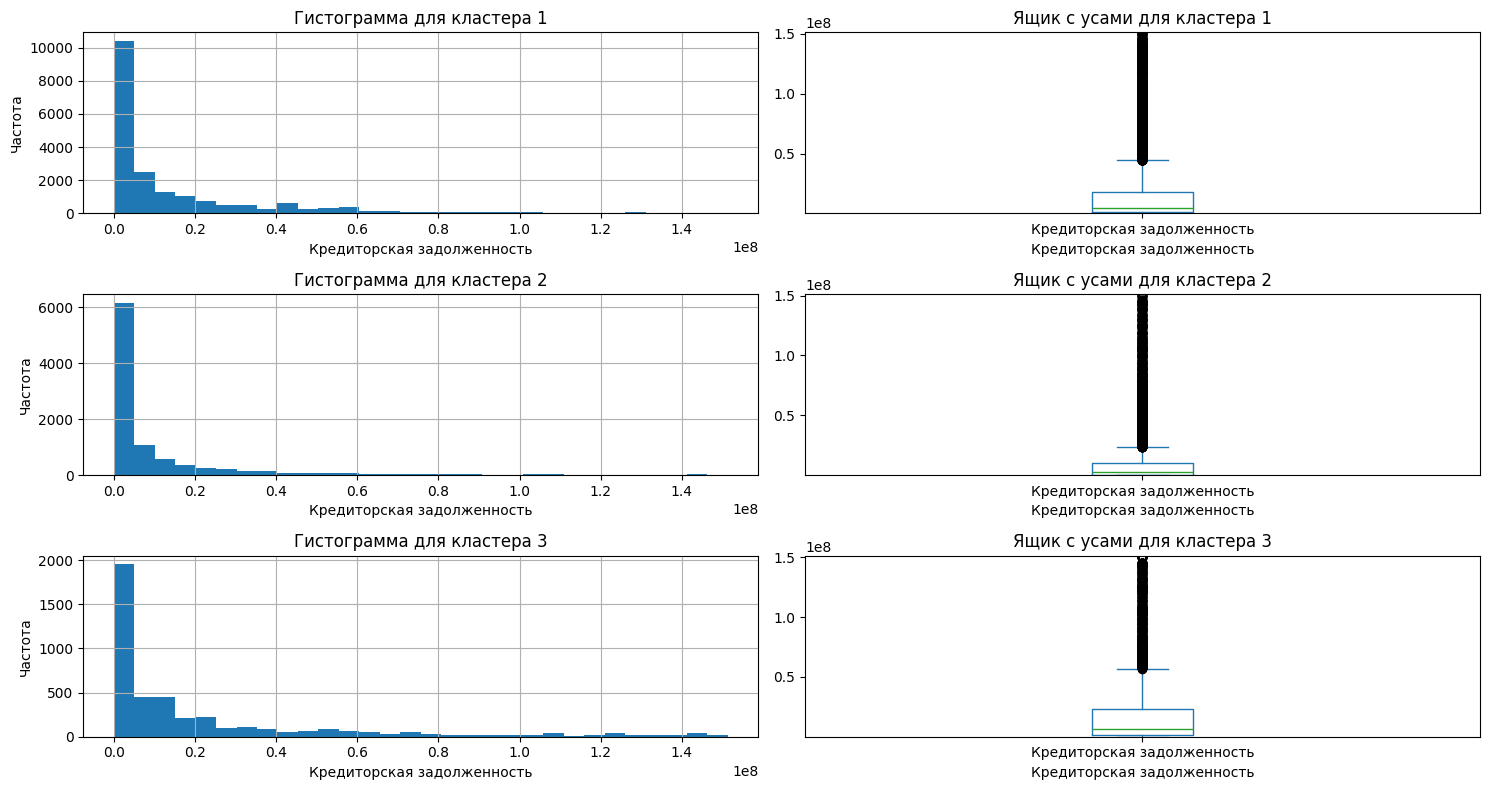

Анализ переменной: Выручка

Описательная статистика для кластера 1:
count    2.200600e+04
mean     5.729528e+07
std      6.939186e+08
min     -4.499000e+06
25%      3.348000e+06
50%      1.271500e+07
75%      4.325800e+07
max      7.713800e+10
Name: Выручка, dtype: float64

Описательная статистика для кластера 2:
count    1.061900e+04
mean     8.241220e+07
std      7.424694e+08
min      0.000000e+00
25%      2.596000e+06
50%      9.951000e+06
75%      3.726450e+07
max      3.158766e+10
Name: Выручка, dtype: float64

Описательная статистика для кластера 3:
count    5.350000e+03
mean     4.516651e+08
std      3.930753e+09
min      0.000000e+00
25%      5.301750e+06
50%      2.512600e+07
75%      9.179800e+07
max      2.173980e+11
Name: Выручка, dtype: float64


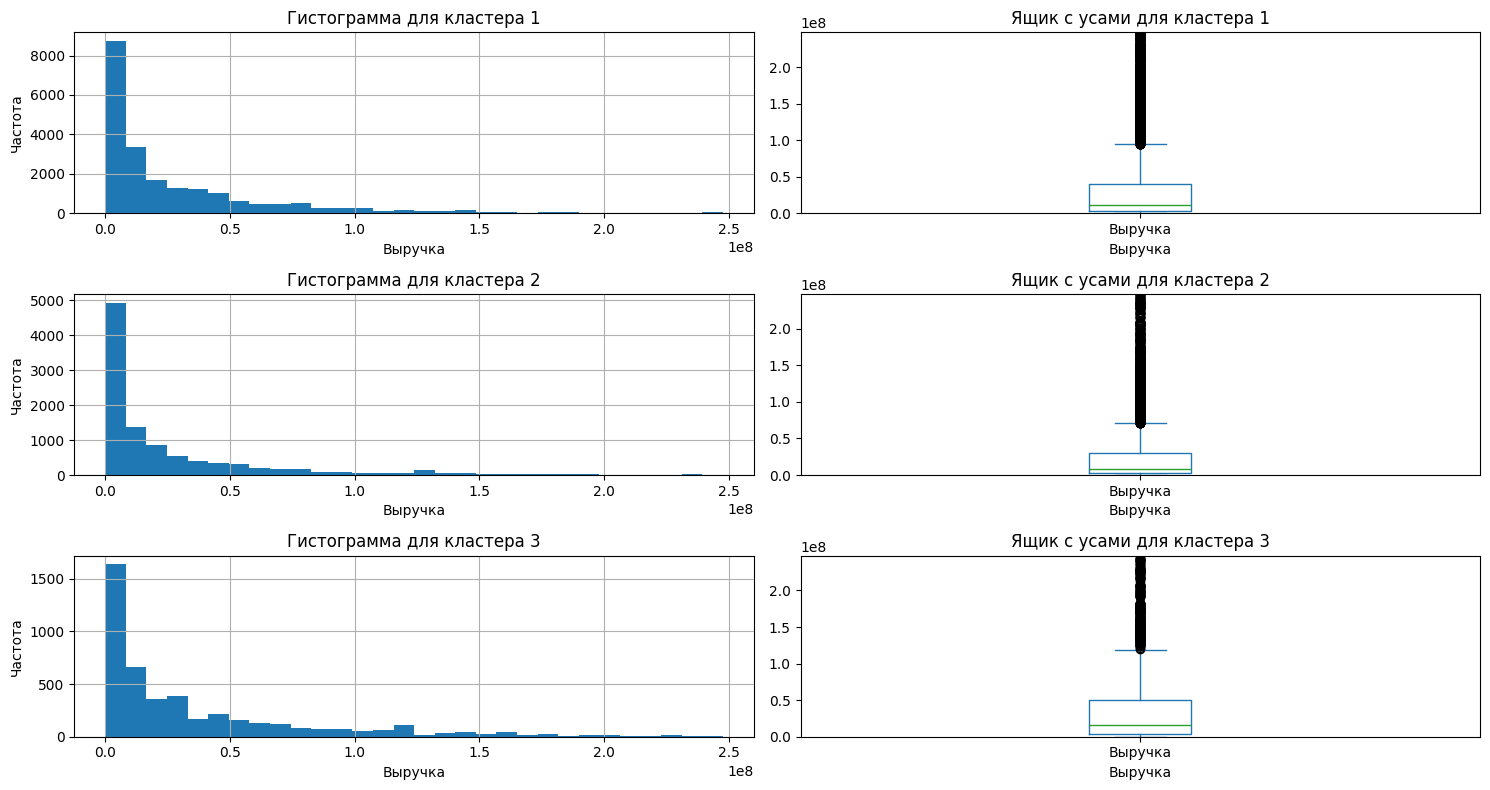

Анализ переменной: Чистая прибыль (убыток)

Описательная статистика для кластера 1:
count    2.208800e+04
mean     1.561031e+06
std      3.525771e+07
min     -1.473653e+09
25%      0.000000e+00
50%      1.750000e+05
75%      1.098000e+06
max      3.469000e+09
Name: Чистая прибыль (убыток), dtype: float64

Описательная статистика для кластера 2:
count    1.084500e+04
mean    -4.141744e+05
std      8.615198e+07
min     -5.191689e+09
25%      3.000000e+03
50%      1.560000e+05
75%      7.940000e+05
max      1.047524e+09
Name: Чистая прибыль (убыток), dtype: float64

Описательная статистика для кластера 3:
count    5.392000e+03
mean    -6.272996e+07
std      6.618683e+08
min     -3.319791e+10
25%     -3.125000e+05
50%      1.900000e+05
75%      1.546000e+06
max      5.257868e+09
Name: Чистая прибыль (убыток), dtype: float64


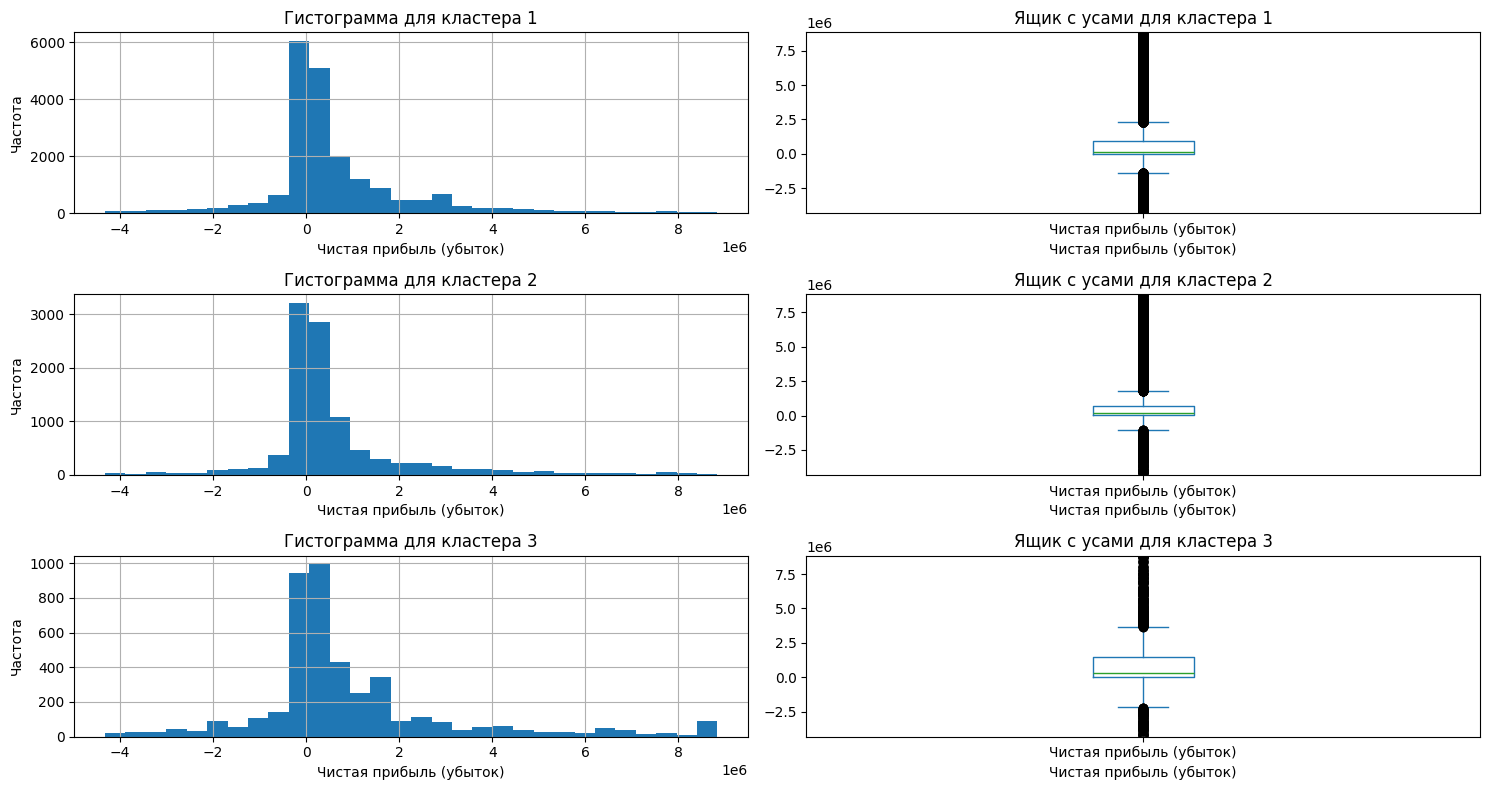

In [42]:
# Список переменных для анализа
variables = [
    'Денежные средства и денежные эквиваленты',
    'Кредиторская задолженность',
    'Выручка',
    'Чистая прибыль (убыток)'
]

def analyze_variable(data, variable):
    print(f"Анализ переменной: {variable}")

    for cluster in data['Cluster'].unique():
        cluster_data = data[data['Cluster'] == cluster]
        print(f"\nОписательная статистика для кластера {cluster}:")
        print(cluster_data[variable].describe())

    lower_bound = data[variable].quantile(0.05)
    upper_bound = data[variable].quantile(0.95)
    filtered_data = data[(data[variable] >= lower_bound) & (data[variable] <= upper_bound)]

    max_value = filtered_data[variable].max()
    min_value = filtered_data[variable].min()

    unique_clusters = filtered_data['Cluster'].unique()
    
    plt.figure(figsize=(15, 8))
    
    for i, cluster in enumerate(unique_clusters):
        cluster_data = filtered_data[filtered_data['Cluster'] == cluster]
        
        plt.subplot(len(unique_clusters), 2, 2*i+1)
        cluster_data[variable].hist(bins=30, range=(min_value, max_value))
        plt.title(f'Гистограмма для кластера {cluster}')
        plt.xlabel(variable)
        plt.ylabel('Частота')
        
        plt.subplot(len(unique_clusters), 2, 2*i+2)
        cluster_data[variable].plot(kind='box', ylim=(min_value, max_value))
        plt.title(f'Ящик с усами для кластера {cluster}')
        plt.xlabel(variable)

    plt.tight_layout()
    plt.savefig(f'D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\Кластеризация\ЮЛ\финансы {variable}.png')    
    
    plt.show()

for var in variables:
    analyze_variable(df, var)